In [ ]:
!pip install -q transformers datasets accelerate matplotlib

In [ ]:
import torch
from datasets import load_dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    LongformerTokenizer,
    LongformerForSequenceClassification,
    set_seed
)
import time
import matplotlib.pyplot as plt
import numpy as np

# Set seed for reproducibility
set_seed(42)

In [ ]:
!pip install -U datasets fsspec

  Using cached fsspec-2025.5.1-py3-none-any.whl.metadata (11 kB)


In [ ]:
# Load IMDB dataset
print("=== Loading IMDB Dataset ===")
dataset = load_dataset("imdb")
sample_text = dataset["test"][0]["text"]

=== Loading IMDB Dataset ===


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/7.81k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

unsupervised-00000-of-00001.parquet:   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

In [ ]:
# Define models and tokenizers
models_info = {
    "BERT": {
        "model_name": "bert-base-uncased",
        "tokenizer": None,
        "model": None
    },
    "DistilBERT": {
        "model_name": "distilbert-base-uncased",
        "tokenizer": None,
        "model": None
    },
    "Longformer": {
        "model_name": "allenai/longformer-base-4096",
        "tokenizer": None,
        "model": None
    }
}

print("\n=== Loading Models ===")
for name, info in models_info.items():
    print(f"Loading {name}...")
    info["tokenizer"] = AutoTokenizer.from_pretrained(info["model_name"], use_fast=True)
    info["model"] = AutoModelForSequenceClassification.from_pretrained(
        info["model_name"], num_labels=2
    ).eval().to("cuda")


=== Loading Models ===
Loading BERT...


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Loading DistilBERT...


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Loading Longformer...


config.json:   0%|          | 0.00/694 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/597M [00:00<?, ?B/s]

Some weights of LongformerForSequenceClassification were not initialized from the model checkpoint at allenai/longformer-base-4096 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Benchmark function
def benchmark_model(name, model, tokenizer, text, max_length):
    inputs = tokenizer(
        text,
        return_tensors="pt",
        truncation=True,
        padding="max_length",
        max_length=max_length
    ).to("cuda")

    # Warmup
    with torch.no_grad():
        _ = model(**inputs)

    # Timed inference
    torch.cuda.synchronize()
    start = time.time()
    with torch.no_grad():
        outputs = model(**inputs)
    torch.cuda.synchronize()
    end = time.time()

    pred = torch.argmax(outputs.logits).item()
    sentiment = "Positive" if pred == 1 else "Negative"
    print(f"{name} | Length: {max_length} | Sentiment: {sentiment} | Time: {end - start:.4f}s")
    return end - start

In [ ]:
# Run benchmark across input lengths
lengths = [256, 512, 1024, 2048, 4096]
results = {name: [] for name in models_info}
test_prompt = "The quick brown fox jumps over the lazy dog. "

print("\n=== Running Benchmarks ===")
for length in lengths:
    test_text = test_prompt * (length // 9)
    for name, info in models_info.items():
        # Only run Longformer for lengths <= 4096
        if name != "Longformer" and length > 512:
            results[name].append(None)
            continue
        if name == "Longformer" and length > 4096:
            results[name].append(None)
            continue
        t = benchmark_model(name, info["model"], info["tokenizer"], test_text, length)
        results[name].append(t)


=== Running Benchmarks ===


model.safetensors:   0%|          | 0.00/597M [00:00<?, ?B/s]

Initializing global attention on CLS token...
Input ids are automatically padded to be a multiple of `config.attention_window`: 512


BERT | Length: 256 | Sentiment: Positive | Time: 0.0246s
DistilBERT | Length: 256 | Sentiment: Positive | Time: 0.0122s
Longformer | Length: 256 | Sentiment: Negative | Time: 0.0959s
BERT | Length: 512 | Sentiment: Positive | Time: 0.0457s
DistilBERT | Length: 512 | Sentiment: Positive | Time: 0.0139s
Longformer | Length: 512 | Sentiment: Negative | Time: 0.0691s
Longformer | Length: 1024 | Sentiment: Negative | Time: 0.1374s
Longformer | Length: 2048 | Sentiment: Negative | Time: 0.3379s
Longformer | Length: 4096 | Sentiment: Negative | Time: 0.6626s



=== Plotting Results ===


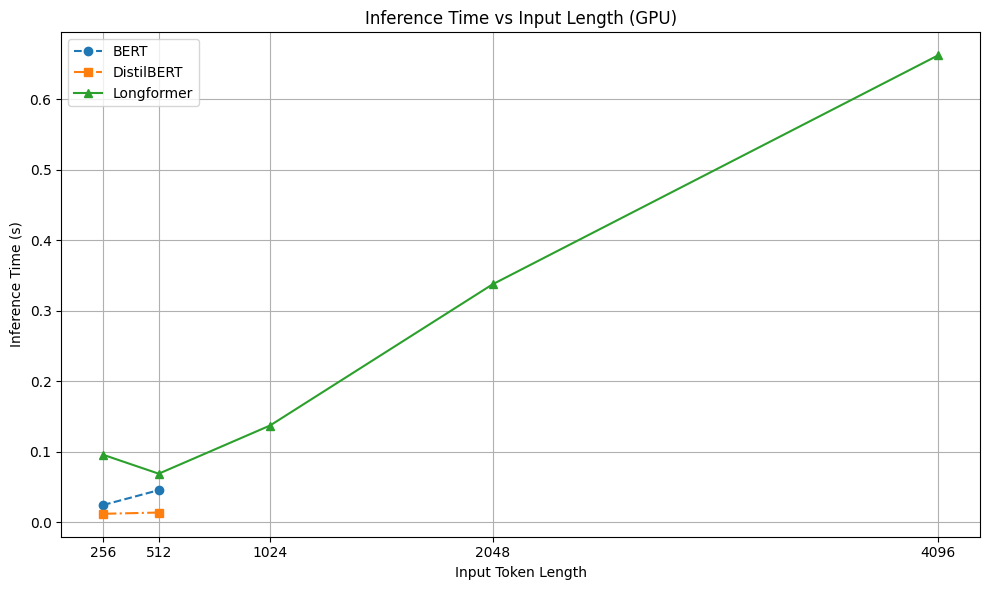

In [ ]:
# Plotting results
print("\n=== Plotting Results ===")
plt.figure(figsize=(10, 6))
markers = {"BERT": "o", "DistilBERT": "s", "Longformer": "^"}
styles = {"BERT": "--", "DistilBERT": "-.", "Longformer": "-"}

for name in models_info:
    times = results[name]
    valid_lengths = [l for i, l in enumerate(lengths) if times[i] is not None]
    valid_times = [t for t in times if t is not None]
    plt.plot(valid_lengths, valid_times, label=name, marker=markers[name], linestyle=styles[name])

plt.title("Inference Time vs Input Length (GPU)")
plt.xlabel("Input Token Length")
plt.ylabel("Inference Time (s)")
plt.grid(True)
plt.legend()
plt.xticks(lengths)
plt.tight_layout()
plt.savefig("transformer_benchmark.png", dpi=300)
plt.show()


In [ ]:
# Summary Table
print("\n=== Benchmark Summary Table ===")
header = f"{'Length':<10} | {'BERT (s)':<10} | {'DistilBERT (s)':<15} | {'Longformer (s)':<15}"
print(header)
print("-" * len(header))
for i, length in enumerate(lengths):
    b = f"{results['BERT'][i]:.4f}" if results['BERT'][i] else "-"
    d = f"{results['DistilBERT'][i]:.4f}" if results['DistilBERT'][i] else "-"
    l = f"{results['Longformer'][i]:.4f}" if results['Longformer'][i] else "-"
    print(f"{length:<10} | {b:<10} | {d:<15} | {l:<15}")

# System Info
print("\n=== System Info ===")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"GPU: {torch.cuda.get_device_name(0)}")
!nvidia-smi --query-gpu=name,memory.total --format=csv



=== Benchmark Summary Table ===
Length     | BERT (s)   | DistilBERT (s)  | Longformer (s) 
-----------------------------------------------------------
256        | 0.0246     | 0.0122          | 0.0959         
512        | 0.0457     | 0.0139          | 0.0691         
1024       | -          | -               | 0.1374         
2048       | -          | -               | 0.3379         
4096       | -          | -               | 0.6626         

=== System Info ===
PyTorch version: 2.6.0+cu124
CUDA available: True
GPU: Tesla T4
name, memory.total [MiB]
Tesla T4, 15360 MiB
